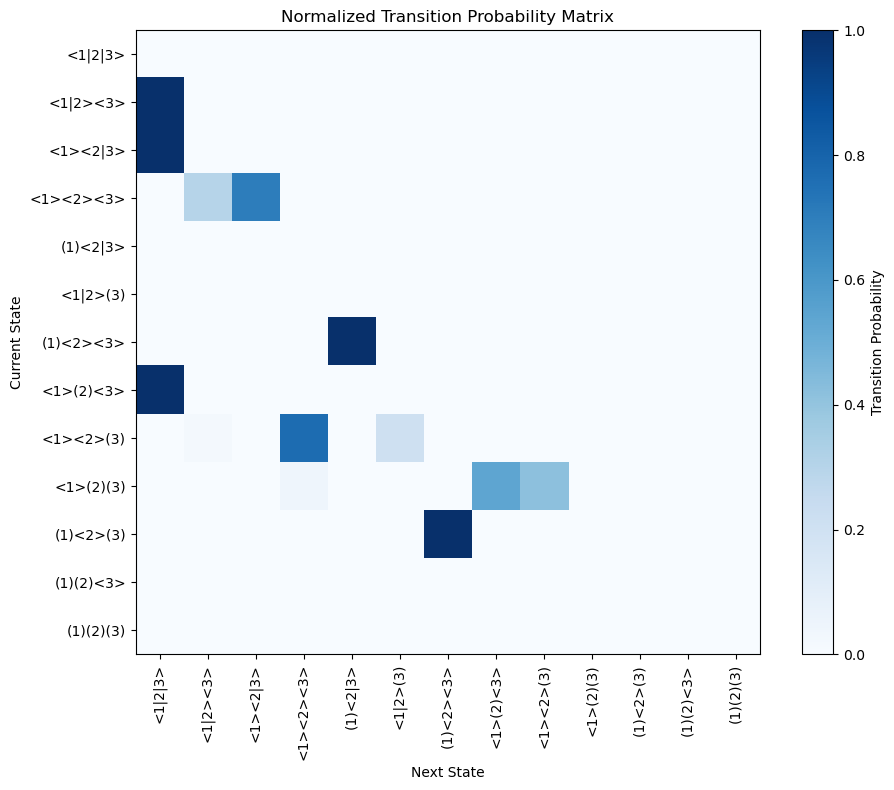

Transitions where tasks revert to human labor:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def calculate_costs(cm, ch, q1, q2, q3):
    """Calculate all possible costs."""
    costs = {
        "<1|2|3>": cm / (q1 * q2 * q3),
        "<1|2><3>": cm / (q1 * q2) + cm / q3,
        "<1><2|3>": cm / q1 + cm / (q2 * q3),
        "<1><2><3>": cm / q1 + cm / q2 + cm / q3,
        "(1)<2|3>": ch + cm / (q2 * q3),
        "<1|2>(3)": ch + cm / (q1 * q2),
        "(1)<2><3>": ch + cm / q2 + cm / q3,
        "<1>(2)<3>": ch + cm / q1 + cm / q3,
        "<1><2>(3)": ch + cm / q1 + cm / q2,
        "<1>(2)(3)": 2 * ch + cm / q1,
        "(1)<2>(3)": 2 * ch + cm / q2,
        "(1)(2)<3>": 2 * ch + cm / q3,
        "(1)(2)(3)": 3 * ch,
    }
    return costs

def find_transitions(cm=1, ch=1.2, q_min=0.01, q_max=0.99, step=0.05):
    """Find transitions between cost configurations."""
    q_values = np.arange(q_min, q_max + step, step)
    states = list(calculate_costs(cm, ch, 0.5, 0.5, 0.5).keys())
    state_indices = {state: i for i, state in enumerate(states)}

    # Initialize transition matrix
    transition_matrix = np.zeros((len(states), len(states)))

    # List to track specific transitions
    human_reversions = []

    # Sweep through all q1, q2, q3 combinations
    for q1, q2, q3 in product(q_values, repeat=3):
        costs = calculate_costs(cm, ch, q1, q2, q3)
        min_cost_state = min(costs, key=costs.get)  # Find the state with the lowest cost

        # Apply a small perturbation to find transitions
        perturbed_costs = calculate_costs(cm, ch, q1 * 1.01, q2 * 1.01, q3 * 1.01)
        next_min_cost_state = min(perturbed_costs, key=perturbed_costs.get)

        # Update the transition matrix (ignore diagonal elements)
        if min_cost_state != next_min_cost_state:
            transition_matrix[state_indices[min_cost_state], state_indices[next_min_cost_state]] += 1

            # Check if a task reverts from machine/automation to human
            if ("<1" in min_cost_state and "(1)" in next_min_cost_state) or \
               ("<2" in min_cost_state and "(2)" in next_min_cost_state) or \
               ("2|" in min_cost_state and "(2)" in next_min_cost_state) or \
               ("|2" in min_cost_state and "(2)" in next_min_cost_state) or \
               ("3>" in min_cost_state and "(3)" in next_min_cost_state):
                human_reversions.append((min_cost_state, next_min_cost_state))

    # Normalize by rows
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    normalized_matrix = transition_matrix / row_sums

    return states, normalized_matrix, human_reversions

def plot_transition_matrix(states, transition_matrix):
    """Plot the normalized transition matrix as a heatmap."""
    plt.figure(figsize=(10, 8))
    plt.imshow(transition_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar(label="Transition Probability")
    plt.xticks(ticks=np.arange(len(states)), labels=states, rotation=90)
    plt.yticks(ticks=np.arange(len(states)), labels=states)
    plt.title("Normalized Transition Probability Matrix")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.grid(False)
    plt.tight_layout()
    plt.savefig("plots/normalized_transition_matrix.png", dpi=300)
    plt.show()

def highlight_human_reversions(human_reversions):
    """Print and highlight transitions where tasks revert to being done by humans."""
    print("Transitions where tasks revert to human labor:")
    for current, next_state in human_reversions:
        print(f"From: {current} --> To: {next_state}")

# Parameters
cm = 1
ch = 10
q_min = 0.01
q_max = 0.99
step = 0.01

# Find transitions
states, normalized_matrix, human_reversions = find_transitions(cm, ch, q_min, q_max, step)

# Plot the normalized transition matrix
plot_transition_matrix(states, normalized_matrix)

# Highlight cases where tasks revert to being done by humans
highlight_human_reversions(human_reversions)
